Term Project

Team: Rain Price, Weston Scott

ECE 523 | Engineering Applications of Machine Learning and Data Analytics

Professor Abhijit Mahalanobis

# Vehicle and People Detection with the FLIR Thermal Dataset

![alt text](problemStatement.png)

## TODO

- Get simple training model working
- Get resulting images and predictions showing
- Run all images through model and check error
- Rewrite Resnet layers to be our own homegrown solution?
- Survive this class ....

## Import Libraries

In [1]:
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image, ImageFilter
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchsummary import summary
from torch.autograd import Variable
from torchvision import transforms as T
from torchvision.transforms import ToTensor, transforms
import copy
import json

## Check to see if input images are the same size

In [2]:
path = 'data/images_thermal_train/data'

imgs = os.listdir(path)
sizes = []
for img in imgs:
    filename = os.path.join(path, img)
    image = Image.open(filename)
    sizes.append(image.size)
print(sizes[-1])
np.unique(sizes, return_counts=True)

(640, 512)


(array([512, 640]), array([10742, 10742]))

## Random Seed, Device Architecture, and Hyperparameters

In [3]:
%matplotlib inline
randomSeed = 13579
np.random.seed(randomSeed)
torch.manual_seed(randomSeed)

print(f'PyTorch Version: {torch.__version__}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(f'PyTorch Device: {device}')

saveModel = True
loadModel = False
modelPath = './model.pt'
numWorkers = 1 
learnRate = 0.006 #2e-5
batchSize = 1
maxEpochs = 10
loadSavedModel = False

PyTorch Version: 2.2.0
PyTorch Device: cuda


## Load Training/ Testing Data

In [4]:
trainPath = './data/images_thermal_train'
valPath = './data/images_thermal_val'
testPath = './data/video_thermal_test'
dataDir = 'data'
jsonFile = 'coco.json'

jsonFiles = { 
              'train' : os.path.join(trainPath, jsonFile),
              'val' : os.path.join(valPath, jsonFile),
              'test' : os.path.join(testPath, jsonFile)
            }

imagePaths = { 
              'train' : trainPath,
              'val' : valPath,
              'test' : testPath
            }

for key, val in jsonFiles.items():
    if os.path.isfile(val):
        print(f'coco.json Exists: {key}, {val}')
    
for key, val in imagePaths.items():
    if os.path.isdir(val):
        print(f'Data Directory Exists: {key}, {val}')
        
labelMap = {
            1:  'person',
            2:  'bike', #(renamed from "bicycle")
            3:  'car', #(this includes pick-up trucks and vans)
            4:  'motor', #(renamed from "motorcycle" for brevity)
            6:  'bus',
            7:  'train',
            8:  'truck', #(semi/freight truck, excluding pickup truck)
            10: 'light', #(renamed from "traffic light" for brevity)
            11: 'hydrant', #(renamed "fire hydrant" for brevity)
            12: 'sign', #(renamed from "street sign" for brevity)
            17: 'dog',
            37: 'skateboard',
            73: 'stroller', #(four-wheeled carriage for a child, also called pram)
            77: 'scooter',
            79: 'other vehicle' #(less common vehicles like construction equipment and trailers)
          }

coco.json Exists: train, ./data/images_thermal_train/coco.json
coco.json Exists: val, ./data/images_thermal_val/coco.json
coco.json Exists: test, ./data/video_thermal_test/coco.json
Data Directory Exists: train, ./data/images_thermal_train
Data Directory Exists: val, ./data/images_thermal_val
Data Directory Exists: test, ./data/video_thermal_test


In [5]:
class ThermalCocoDataset(Dataset):
    def __init__(self, json_file, image_dir, transform=None):
        self.json_file = json_file
        self.image_dir = image_dir
        self.transform = transform
        self._load_json()

    def _load_json(self):
        with open(self.json_file, 'r') as f:
            data = json.load(f)
        
        self.annotations = data['annotations']
        self.images = data['images']
    
    def _map_images_to_id(self, id):
        for entry in self.images:
            if entry['id'] == id:
                return entry['file_name']

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        image_id = annotation['image_id']
        image_file_name = self._map_images_to_id(image_id)
        image_file = os.path.join(self.image_dir, f"{image_file_name}")
        image = cv2.imread(str(image_file), cv2.IMREAD_GRAYSCALE).astype(np.float32)

        # Apply transforms if provided
        if self.transform:
            image = self.transform(image)

        # Assuming annotation format: [x, y, width, height]
        bbox = torch.tensor(annotation['bbox'])
        label = annotation['category_id']

        return image, bbox, label

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to PyTorch tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize image
])

trainData = ThermalCocoDataset(jsonFiles['train'], imagePaths['train'], transform=transform)
valData = ThermalCocoDataset(jsonFiles['val'], imagePaths['val'], transform=transform)
testData = ThermalCocoDataset(jsonFiles['test'], imagePaths['test'], transform=transform)

trainLoader = DataLoader(trainData, batch_size=batchSize, shuffle=True, num_workers=numWorkers)
valLoader = DataLoader(valData, batch_size=batchSize, shuffle=True, num_workers=numWorkers)
testLoader = DataLoader(testData, batch_size=batchSize, shuffle=False, num_workers=numWorkers)

## Helpful Function Definitions

In [6]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[0], bb[1]), bb[2], bb[3], color=color,
                         fill=False, lw=2)

def show_corner_bb(im, bb, c=None, cLabel='', color='red', createFig=False):
    if createFig:
        plt.figure(figsize=(6,6))
        if not cLabel == '':
            plt.title(f'{cLabel} Class: {c}')
    plt.imshow(im.squeeze(), cmap="gray")
    plt.gca().add_patch(create_corner_rect(bb, color=color))

## Sample Imagery From Training Data

### Original Images (Training)

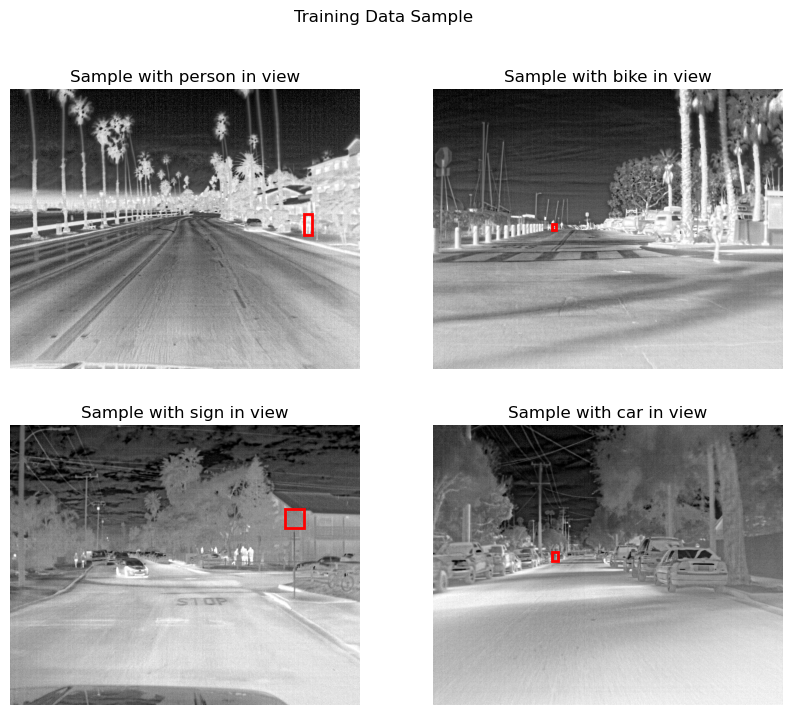

In [7]:
figure = plt.figure(figsize=(10, 8))
plt.suptitle('Training Data Sample')
cols, rows = 2, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainData), size=(1,)).item()
    img, bbox, label = trainData[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f'Sample with {labelMap[label]} in view')
    plt.axis("off")
    show_corner_bb(img, bbox)
plt.show()

### Original Images (Validation)

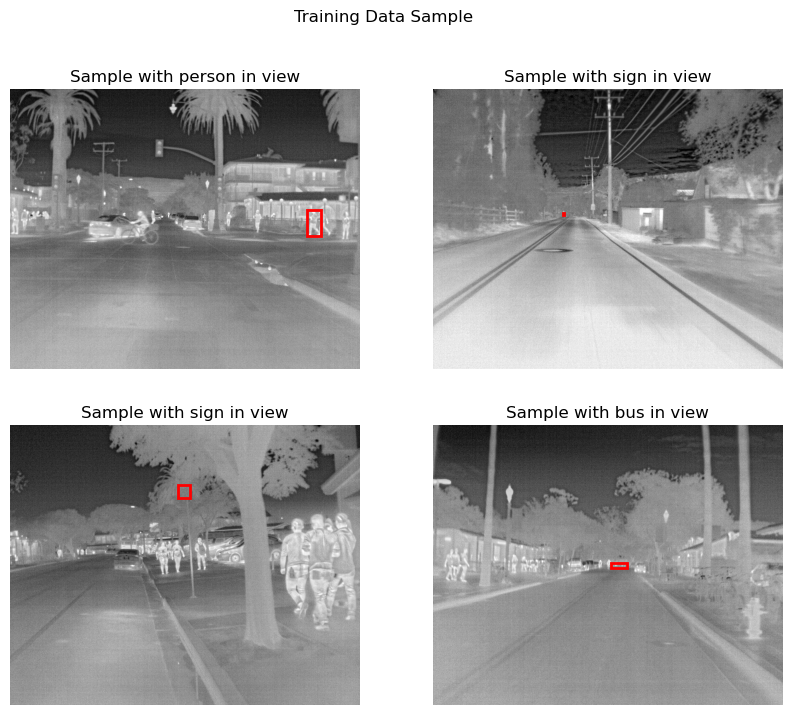

In [8]:
figure = plt.figure(figsize=(10, 8))
plt.suptitle('Training Data Sample')
cols, rows = 2, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(valData), size=(1,)).item()
    img, bbox, label = trainData[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f'Sample with {labelMap[label]} in view')
    plt.axis("off")
    show_corner_bb(img, bbox)
plt.show()

### Original Images (Testing)

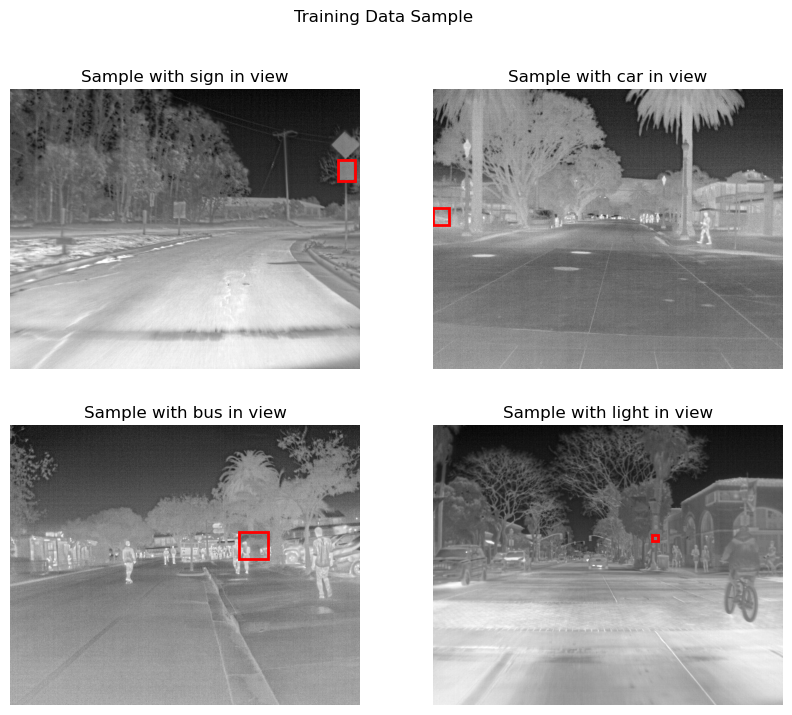

In [9]:
figure = plt.figure(figsize=(10, 8))
plt.suptitle('Training Data Sample')
cols, rows = 2, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(testData), size=(1,)).item()
    img, bbox, label = trainData[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f'Sample with {labelMap[label]} in view')
    plt.axis("off")
    show_corner_bb(img, bbox)
plt.show()

## Model Definition

In [13]:
class ClassificationDetection(nn.Module):
    def __init__(self):
        super(ClassificationDetection, self).__init__()
        inplace = False
        resnet = models.resnet18(weights=None)  # Using a lighter ResNet architecture
        
        self.relu = nn.ReLU(inplace=inplace)
        # Modify the first convolution layer to accept (1, 512, 640) input
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)  # Reduced kernel size
        
        layers = list(resnet.children())[:6]  # Use fewer layers
        self.features = nn.Sequential(*layers)
        
        # Reduced width of the fully connected layers
        self.classifier = nn.Sequential(nn.Linear(128, 64), 
                                        nn.ReLU(inplace=inplace), 
                                        nn.Linear(64, len(labelMap)), 
                                        nn.Softmax(1))
        self.bb = nn.Sequential(nn.Linear(128, 64),
                                nn.ReLU(inplace=inplace),
                                nn.Linear(64, 4))
        
    def forward(self, x):
        x = self.features(x)
        x = self.relu(x) # Use inplace ReLU for memory efficiency
        x = nn.AdaptiveAvgPool2d((1, 1))(x)
        x = x.view(x.size(0), -1)
        classifier = self.classifier(x)
        bbox = self.bb(x)
        return classifier, bbox
    
summary(ClassificationDetection(), (1,512,640))

model = ClassificationDetection()

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 64, 80]         --
|    └─Conv2d: 2-1                       [-1, 64, 256, 320]        576
|    └─BatchNorm2d: 2-2                  [-1, 64, 256, 320]        128
|    └─ReLU: 2-3                         [-1, 64, 256, 320]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 128, 160]        --
|    └─Sequential: 2-5                   [-1, 64, 128, 160]        --
|    |    └─BasicBlock: 3-1              [-1, 64, 128, 160]        73,984
|    |    └─BasicBlock: 3-2              [-1, 64, 128, 160]        73,984
|    └─Sequential: 2-6                   [-1, 128, 64, 80]         --
|    |    └─BasicBlock: 3-3              [-1, 128, 64, 80]         230,144
|    |    └─BasicBlock: 3-4              [-1, 128, 64, 80]         295,424
├─ReLU: 1-2                              [-1, 128, 64, 80]         --
├─Sequential: 1-3                        [-1, 15]                

## Set Criterion and Optimizer

In [14]:
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=learnRate)
print(f'Optimizer: {optimizer}')

criterion = nn.CrossEntropyLoss()   
print(f'\nCriterion: {criterion}')

criterion_bbox = nn.SmoothL1Loss()   
print(f'\nCriterion bbox: {criterion_bbox}')

Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.006
    maximize: False
    weight_decay: 0
)

Criterion: CrossEntropyLoss()

Criterion bbox: SmoothL1Loss()


## Load Trained Model (If Needed)

In [15]:
if loadModel:
    model = ClassificationDetection(len(labelMap), len(labelMap))
    optimizer = optimizer
    checkpoint = torch.load(modelPath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    criterion = checkpoint['loss']  

## Train Model

In [17]:
model = model.to(device)
criterion = criterion.to(device)
criterion_bbox = criterion_bbox.to(device)

if not loadModel:
     
    exp_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
    trainLoss = []

    for epoch in range(1, maxEpochs+1):
        epochLoss = []
        testEpochLoss = []
        model.train()

        for i, (images, bbox, labels) in enumerate(trainLoader):
            optimizer.zero_grad()
            images = images.to(device)
            bbox = bbox.to(device)
            labels = labels.to(device)         
            predLabels, predBoxes = model(images)
            lossLabels = criterion(predLabels, labels.to(device))
            lossBoxes = criterion_bbox(predBoxes, bbox).sum(1)
            loss = lossLabels + lossBoxes
            loss.backward()          
            optimizer.step()
            lossVal = loss.item()
            epochLoss.append(float(lossVal))

        trainLoss.append(np.mean(epochLoss))
        exp_lr_scheduler.step(trainLoss[-1])
                
        print(f'[Epoch: {epoch}/{maxEpochs}] Loss: {np.round(trainLoss[-1], 5)}')

        if saveModel and epoch % 5 == 0: ## save model every 5th epoch
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                    }, modelPath)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

## Save Model (If Needed)

In [ ]:
if saveModel and not loadModel:
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            'loss_bbox': criterion_bbox,
            }, modelPath)

## Learning Curve

In [ ]:
if not loadModel:
    print(f'Final MSE ({maxEpochs} epochs): {trainLoss[-1]}\n')
    
    f = plt.figure(figsize=(10,8))
    plt.plot(trainLoss, label="train")
    plt.xlabel("epochs")
    plt.ylabel("cross entropy")
    plt.title("Epochs vs. Loss Function")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

## Sample Imagery of Model Output

### Training Images Samples

In [ ]:
# trainImages, trainLabels, trainImagesFlipped = next(iter(trainLoader))
# samples = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# model.eval()
# with torch.no_grad():
#     outputs, __ = model(trainImages.to(device))

# j = 0
# for i, label in enumerate(trainLabels):
#     if label.item() in samples:
#         f = plt.figure(figsize=(12, 4))      
#         ax1 = f.add_subplot(131)
#         ax1.imshow(trainImages[i].squeeze(), cmap='gray')
#         ax1.axis('off')
#         ax1.set_title(f'Original - {label.item()}')
#         ax2 = f.add_subplot(132)
#         ax2.imshow(outputs[i].detach().cpu()[0].squeeze(), cmap='gray')
#         ax2.axis('off')
#         ax2.set_title(f'Reconstruction (Flipped) - {label.item()}')
#         plt.tight_layout()
#         plt.show()
        
#         samples.remove(label.item())
#         j += 1

### Test Images Samples

In [ ]:
# testImages, testLabels, testImagesFlipped = next(iter(testLoader))
# samples = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# model.eval()
# with torch.no_grad():
#     outputs, __ = model(testImages.to(device))

# j = 0
# for i, label in enumerate(testLabels):
#     if label.item() in samples:
#         f = plt.figure(figsize=(12, 4))      
#         ax1 = f.add_subplot(131)
#         ax1.imshow(testImages[i].squeeze(), cmap='gray')
#         ax1.axis('off')
#         ax1.set_title(f'Original - {label.item()}')
#         ax2 = f.add_subplot(132)
#         ax2.imshow(outputs[i].detach().cpu()[0].squeeze(), cmap='gray')
#         ax2.axis('off')
#         ax2.set_title(f'Reconstruction (Flipped) - {label.item()}')
#         plt.tight_layout()
#         plt.show()
        
#         samples.remove(label.item())
#         j += 1